<a href="https://colab.research.google.com/github/leokan92/class/blob/main/Aula_4_Case_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definição do problema

Vamos tratar um problema clássico de várias indústrias que é previsão da demanda dentro do varejo (*retail*).

**Utilidade:** Realizar planejamento da produção, operação, etc.

**Objetivo:** prever o valor da demanda em um horizonte determinado de tempo.

# Revisão da Literatura

Vamos aqui fazer uma revisão da literatura para termos alguma base de quais técnicas vamos usar, quais os dados e como vamos medir e avaliar os resultados.
______________________________________________


**Forecasting aggregate retail sales:: a comparison of artificial neural networks and traditional methods** (2001)
https://www.sciencedirect.com/science/article/abs/pii/S0969698900000114

Aplica regressão multivariada, ARIMA, Suavização Exponencial de Winters e ANN para prever o preço dos ativos. Neste caso ANN foi melhor usanod como métrica apenas o MAPE.

Aqui a venda agredada no varejo é prevista. Não a venda de cada produto individualmente.

De  Janeiro de 1978 até Dezembro de 1985 para treinamento e de Janeiro de 1986 até Abril de 1995. *Current Business Report, Monthly Retail Trade: Sales and Inventories*.

______________________________________________

**SKU demand forecasting in the presence of promotions** (2009)
https://www.sciencedirect.com/science/article/pii/S0957417409004035

Aqui vemos a previsão da demanda sobre a influência de promoções em uma mercearia europeia. Aqui, arvores de regressão são usadas para realizar as previsões.

O conjunto de dados é composto pela combinação de 11936 lojas SKU semana onde temos 51 semanas para treino e 25 semanas para teste.

As variaveis no conjunto de dados são: vendas na semana com e sem promoção, numero de promoções, preço regular e corte de preço.

As técnicas usadas: Regressão Linear Passo a Passo, Regressão por Vetores de Suporte, Árvore de Regressão cada um deles com diferentes combinações de hiper-parâmetros.

Foram usadas como métricas MAE, e MAPE. Eles usam um teste estatístico para verificar a significancia da diferença entre os modelos

Quando promoções são usadas, as arvores de regressão tem melhor desempenho, do contrário é a regressão por vetores de suporte.

______________________________________________
**Forecasting seasonal demand for retail: A Fourier time-varying
grey model** (2024)
https://www.sciencedirect.com/science/article/pii/S0169207023001383

Aqui é proposto um Modelo Cinza Variante no Tempo de Fourie. Aqui, os parâmetros aprendidos são a ordem de Fourie.

O conjunto de dados usado é a base pública M5 e o modelo é treinado e testado usando um avaliação deslizante para que se tenha uma média e um desvio padrão do erro. O teste estatístico proposto segue o método de outros autores  usanods multiplos conjuntos de dados. para cada métrica, é feito um ranking. O teste estatístico é feito em torno da média dos rankings usando signficancia de 5%.

________________________________________________
**A Comparative Study on Forecasting of Retail Sales**
https://arxiv.org/ftp/arxiv/papers/2203/2203.06848.pdf


Aqui os modelos ARIMA, Prophet, LightGBM são usados para prever as séries temporais do conjunto de dados M5.

Aqui nem uma comparação estatística é feita e aparentemente ARIMA se mostrou como o melhor modelo.

________________________________________________
**Retail sales forecasting with meta-learning**
https://www.sciencedirect.com/science/article/pii/S0377221720304847

Aqui é proposto um modelo de combinação (ensemble) que basicamente é a combinação do de uma rede neural convolucinal mais a média ponderada de M regressores.

Novamente, aqui é usado o ranking médio e feito o Nemenyi Rank test. GBRT fo i o melhor previsor. Além disso mostrou que a técnica de combinação proposta é melhor que algumas outras técncias tal como gradient boosting. This work uses IRI dataset (Bronnenberg, Kruger, 2008).

________________________________________________
**Ensemble approach for time series analysis in demand forecasting: Ensemble learning**
https://ieeexplore.ieee.org/abstract/document/8001123

Aqui foi usado um banco de dados de 4000 lijas  de um mercado turco. O artigo omite muitos detalhes de quais técnicas foram combinadas e o resultado é colocado sem muitas comparações.
_________________________________________________
**A machine learning approach for forecasting hierarchical time series**
https://www.sciencedirect.com/science/article/pii/S0957417421005431

As técnicas aqui aprensentadas utilizam o conceito de previsão hierárquica para ajustar os modelos.

São usados 2 conjuntos de dados de mercados: - Italian Dataset, Walmart Dataset

# Experimento

Assim como outros artigos, vamos utilizadas os dados públicos de previsão no varejo para testar diferentes abordagens para previsão de series de tempo.

## Carregando os dados

In [1]:
import pandas as pd
import numpy as np

In [2]:
# This is the path to the files downloaded from the M5 kaggle competition: https://www.kaggle.com/competitions/m5-forecasting-accuracy
files_path = '/content/drive/MyDrive/Aulas/Impacta/Aulas - Aprendizado de máquina/Aula 4/Case/Data/m5-forecasting-accuracy'

# Load the data (modify the file path as needed)
sales_data = pd.read_csv(f'{files_path}/sales_train_validation.csv')

In [3]:
# Filter rows where 'id' column contains 'FOODS'
filtered_sales_data = sales_data[sales_data['id'].str.contains('FOODS')]
filtered_sales_data = filtered_sales_data[sales_data['state_id'].str.contains('CA')]

np.random.seed(0) # We fix the seed to aways have the same sample selection

# Sample 5 unique store IDs
unique_item_ids = filtered_sales_data['item_id'].unique()
unique_item_ids = np.random.choice(unique_item_ids, 300, replace=False)

filtered_sales_data = filtered_sales_data[filtered_sales_data['item_id'].isin(unique_item_ids)]

sales_data = filtered_sales_data.copy()
sales_data.reset_index(drop=True, inplace=True)

del filtered_sales_data

<ipython-input-3-0d0f1769b7e2>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_sales_data = filtered_sales_data[sales_data['state_id'].str.contains('CA')]


In [4]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1_002_CA_1_validation,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,0,1,0,1,...,1,3,1,0,0,1,2,0,0,0
1,FOODS_1_003_CA_1_validation,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,0,0,0,0,...,3,0,2,1,1,0,1,0,1,0
2,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,3,9,3,3,...,3,1,1,2,0,2,2,1,4,1
3,FOODS_1_006_CA_1_validation,FOODS_1_006,FOODS_1,FOODS,CA_1,CA,0,0,3,1,...,1,3,1,0,2,1,2,3,2,2
4,FOODS_1_010_CA_1_validation,FOODS_1_010,FOODS_1,FOODS,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


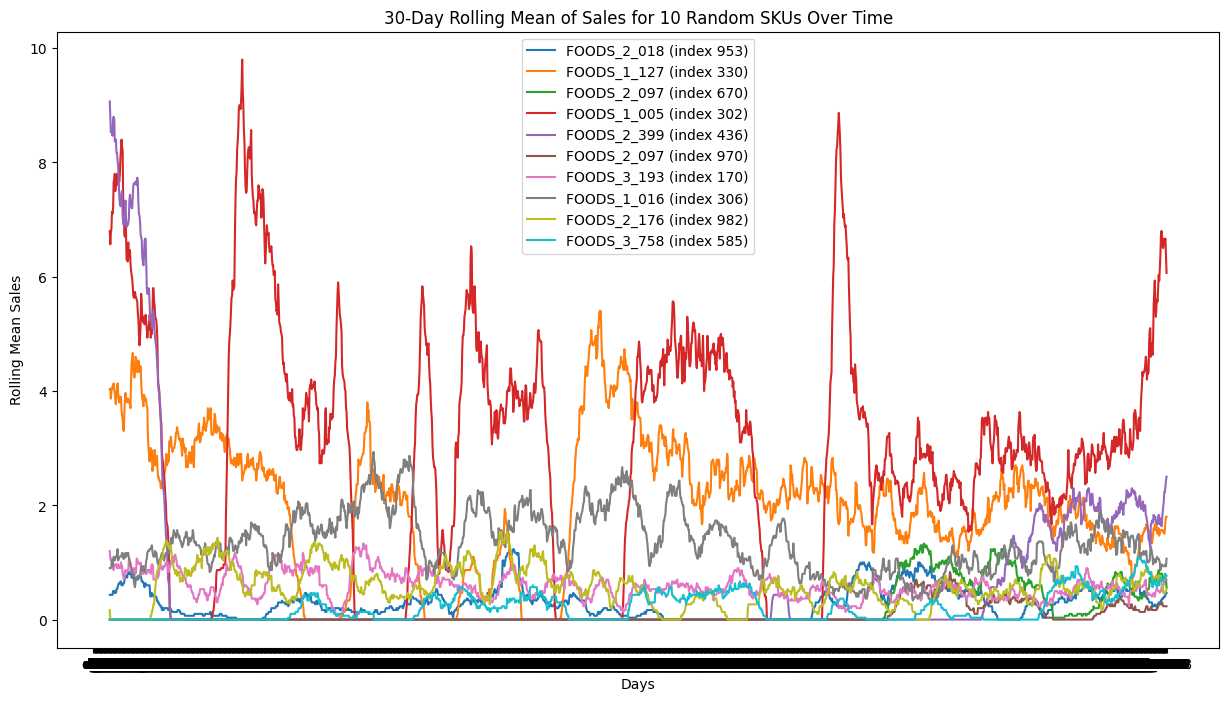

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'sales_data' is already loaded and contains columns like 'd_1', 'd_2', etc., representing daily sales

# Filter out non-sales columns
sales_only = sales_data.filter(regex='^d_', axis=1)

# Select 10 random SKUs
selected_skus_indices = np.random.choice(sales_data.index, 10, replace=False)
selected_skus_data = sales_only.loc[selected_skus_indices]

# Define the window for rolling mean
rolling_window = 30  # for example, a 30-day rolling window

# Plotting
plt.figure(figsize=(15, 8))
for i, sku_index in enumerate(selected_skus_indices):
    sku_id = sales_data.loc[sku_index, 'item_id']
    rolling_mean = selected_skus_data.loc[sku_index, :].rolling(window=rolling_window).mean()
    plt.plot(selected_skus_data.columns, rolling_mean, label=f'{sku_id} (index {sku_index})')

plt.title(f'30-Day Rolling Mean of Sales for 10 Random SKUs Over Time')
plt.xlabel('Days')
plt.ylabel('Rolling Mean Sales')
plt.legend()
plt.show()

del selected_skus_data
del selected_skus_indices
del sales_only

In [6]:
# Melt the sales data to long format
sales_long = pd.melt(sales_data,
                     id_vars=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                     var_name='day',
                     value_name='sale_qty')

# Extracting day numbers and converting to float first to handle NaN values
sales_long['day'] = sales_long['day'].str.extract('(\d+)').astype(float)

# You can check if there are any NaN values and handle them as needed
nan_count = sales_long['day'].isna().sum()
if nan_count > 0:
    print(f"There are {nan_count} NaN values in the 'day' column")

# Assuming we can drop NaN values (or you can handle them differently)
sales_long = sales_long.dropna(subset=['day'])

# Now safely convert to int
sales_long['day'] = sales_long['day'].astype(int)

sales_long.reset_index(drop=True, inplace=True)

del sales_data

There are 1200 NaN values in the 'day' column


<ipython-input-6-434421049cc9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_long['day'] = sales_long['day'].astype(int)


In [7]:
calendar_data = pd.read_csv(f'{files_path}/calendar.csv')

In [8]:
# Convert 'date' in the calendar DataFrame to a sequential day number
calendar_data['day'] = pd.to_datetime(calendar_data['date']).sub(pd.to_datetime(calendar_data['date'].iloc[0])).dt.days + 1

# Preview the calendar data
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,2
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,3
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,4
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,5


In [9]:
# Merge the sales_long and calendar DataFrames
merged_data_calendar = pd.merge(sales_long, calendar_data, on='day', how='left')
del calendar_data
del sales_long

In [10]:
price_data = pd.read_csv(f'{files_path}/sell_prices.csv')

In [11]:
# Merge sales and price data
merged_data = pd.merge(merged_data_calendar, price_data, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
del price_data
del merged_data_calendar

In [12]:
# Count the number of unique item_ids in the filtered_data DataFrame
unique_item_id_count = merged_data['item_id'].nunique()

# Print the count
print(f"Number of unique item_ids: {unique_item_id_count}")
del unique_item_id_count

Number of unique item_ids: 300


In [13]:
merged_data.columns

Index(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'sale_qty', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

## Análise de dados e processamento


In [14]:
# Identify the item_id with all NaN prices
item_ids_with_all_nan_prices = merged_data.groupby('item_id')['sell_price'].apply(lambda x: x.isna().all())

# Filtering out the item_ids to exclude (those with all NaN dates)
item_ids_to_exclude = item_ids_with_all_nan_prices[item_ids_with_all_nan_prices].index.tolist()

# Now filter out these item_ids from the merged_data
filtered_data = merged_data[~merged_data['item_id'].isin(item_ids_to_exclude)]

# Preview the filtered data
filtered_data.head()

,item_id,dept_id,cat_id,store_id,state_id,day,sale_qty,date,wm_yr_wk,weekday,...,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,1,0,2011-01-29,11101,Saturday,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,7.88
1,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,1,0,2011-01-29,11101,Saturday,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,2.88
2,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,Saturday,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,2.94
3,FOODS_1_006,FOODS_1,FOODS,CA_1,CA,1,0,2011-01-29,11101,Saturday,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1.97
4,FOODS_1_010,FOODS_1,FOODS,CA_1,CA,1,0,2011-01-29,11101,Saturday,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN


In [15]:
# Count the number of unique item_ids in the filtered_data DataFrame
unique_item_id_count = filtered_data['item_id'].nunique()

# Print the count
print(f"Number of unique item_ids: {unique_item_id_count}")

Number of unique item_ids: 300


In [16]:
# Ensure the data is sorted by date
filtered_data.sort_values(by='date', inplace=True)

# Create two Series: one filled forward and one filled backward
forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
backward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='bfill')

# Combine the results, preferring the forward fill
combined_fill = forward_filled.combine_first(backward_filled)

# Assign the combined result back to the sell_price column
filtered_data['sell_price'] = combined_fill

In [17]:
# Check if there are any remaining NaN values in sell_price
remaining_nan = filtered_data['sell_price'].isna().sum()
print(f"Remaining NaN values in sell_price: {remaining_nan}")

Remaining NaN values in sell_price: 0


In [18]:
del combined_fill
del backward_filled
del forward_filled
del item_ids_to_exclude
del item_ids_with_all_nan_prices

### Tratando as variáveis categoricas

In [19]:
categorical_columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
                       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

for col in categorical_columns:
    filtered_data[col] = filtered_data[col].astype('category').cat.codes

In [20]:
filtered_data['year'] = filtered_data['year'] - filtered_data['year'].min()

In [21]:
filtered_data['weekday'] = filtered_data['weekday'].astype('category').cat.codes

In [22]:
data = filtered_data

### Inclusão de features de séries temporais

In [23]:
window_sizes_lag = [1, 2, 3, 4, 5, 6, 7, 14, 30, 60]

for window in window_sizes_lag:
    data[f'lag_{window}'] = data.groupby(['item_id', 'store_id'])['sale_qty'].shift(window)

In [24]:
window_sizes_rolling = [2, 3, 4, 7, 14, 30, 60]

for window in window_sizes_rolling:
    rolling_mean = data.groupby(['item_id', 'store_id'])['sale_qty'].transform(lambda x: x.rolling(window=window).mean())
    rolling_sum = data.groupby(['item_id', 'store_id'])['sale_qty'].transform(lambda x: x.rolling(window=window).sum())

    data[f'rolling_mean_{window}'] = rolling_mean
    data[f'rolling_sum_{window}'] = rolling_sum

In [25]:
# Handling NaN values
data.dropna(inplace=True)
data.drop(['d'],axis = 1,inplace=True)

In [26]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
data[(data['item_id'] == 1) & (data['store_id'] == 1)].head(5)

,item_id,dept_id,cat_id,store_id,state_id,day,sale_qty,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_14,lag_30,lag_60,rolling_mean_2,rolling_sum_2,rolling_mean_3,rolling_sum_3,rolling_mean_4,rolling_sum_4,rolling_mean_7,rolling_sum_7,rolling_mean_14,rolling_sum_14,rolling_mean_30,rolling_sum_30,rolling_mean_60,rolling_sum_60
72301,1,0,0,1,0,61,1,2011-03-30,11109,6,5,3,0,-1,-1,-1,-1,0,0,0,2.88,1,1,8,2,3,1,3,1,0,8,1.0,2.0,1.000000,3.0,2.75,11.0,2.428571,17.0,2.214286,31.0,1.966667,59.0,1.716667,103.0
73501,1,0,0,1,0,62,3,2011-03-31,11109,4,6,3,0,-1,-1,-1,-1,0,0,0,2.88,1,1,1,8,2,3,1,0,0,2,2.0,4.0,1.666667,5.0,1.50,6.0,2.714286,19.0,2.428571,34.0,2.066667,62.0,1.733333,104.0
74701,1,0,0,1,0,63,5,2011-04-01,11109,0,7,4,0,-1,-1,-1,-1,1,1,0,2.88,3,1,1,1,8,2,3,2,0,2,4.0,8.0,3.000000,9.0,2.50,10.0,3.000000,21.0,2.642857,37.0,2.233333,67.0,1.783333,107.0
75901,1,0,0,1,0,64,1,2011-04-02,11110,2,1,4,0,-1,-1,-1,-1,1,0,1,2.88,5,3,1,1,1,8,2,3,0,1,3.0,6.0,3.000000,9.0,2.50,10.0,2.857143,20.0,2.500000,35.0,2.266667,68.0,1.783333,107.0
77101,1,0,0,1,0,65,0,2011-04-03,11110,3,2,4,0,-1,-1,-1,-1,1,1,1,2.88,1,5,3,1,1,1,8,2,1,0,0.5,1.0,2.000000,6.0,2.25,9.0,1.714286,12.0,2.357143,33.0,2.233333,67.0,1.783333,107.0


### Tratando as variáveis contínuas

Deste ponto em diante precisamos quebrar o conjunto de treino/validação/teste para evitar data leakage

In [27]:
import pandas as pd

# Assuming 'data' is your DataFrame

# Create the target variable (next day's sale_qty)
data['target'] = data.groupby(['item_id', 'store_id'])['sale_qty'].shift(-1)

# Drop rows with NaN in target due to the shift operation
data.dropna(subset=['target'], inplace=True)

# Splitting the data into features and target
X = data.drop(['target', 'wm_yr_wk', 'date'], axis=1)
y = data['target']

# Lists to store individual DataFrames for concatenation
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Split index for each series
split_ratio = 0.8

for (item, store), group in data.groupby(['item_id', 'store_id']):
    split_index = int(len(group) * split_ratio)

    X_train_list.append(group.iloc[:split_index].drop(['target', 'wm_yr_wk', 'date'], axis=1))
    X_test_list.append(group.iloc[split_index:].drop(['target', 'wm_yr_wk', 'date'], axis=1))
    y_train_list.append(group.iloc[:split_index]['target'])
    y_test_list.append(group.iloc[split_index:]['target'])

# Concatenate all individual DataFrames
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

# Now, X_train, X_test, y_train, and y_test are ready for model training and evaluation


In [28]:
from sklearn.preprocessing import StandardScaler

# List of continuous columns to scale
non_continuous_columns = categorical_columns + ['d', 'date','wm_yr_wk']

continuous_columns = X_train.columns.difference(non_continuous_columns)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the continuous variables of the training data
scaler.fit(X_train[continuous_columns])

# Transform the continuous variables in both training and test sets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_columns] = scaler.transform(X_train[continuous_columns])
X_test_scaled[continuous_columns] = scaler.transform(X_test[continuous_columns])

In [29]:
# Convert features to numeric type
numeric_features = ['sale_qty', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_14', 'lag_30', 'lag_60']
X_train[numeric_features] = X_train[numeric_features].apply(pd.to_numeric, errors='coerce')
X_test[numeric_features] = X_test[numeric_features].apply(pd.to_numeric, errors='coerce')

# After converting, you may need to drop NaN values that were introduced during conversion
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Convert the target variable to numeric type
y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

# After converting, you may need to drop NaN values that were introduced during conversion
y_train.dropna(inplace=True)
y_test.dropna(inplace=True)

## Análise realizando agrupamento

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming filtered_data is your preprocessed DataFrame

# Features to be used for clustering
features_for_clustering = X_train.columns.difference(['store_id', 'cat_id', 'state_id'])

# Range of potential number of clusters to test
cluster_range = range(1, 6)  # For example, testing 1 to 10 clusters

# Store the inertia values for each number of clusters
inertia_values = []

for k in cluster_range:
    # Create KMeans instance for different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train[features_for_clustering])

    # Append the inertia (sum of squared distances to closest cluster center)
    inertia_values.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.show()

del features_for_clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.cluster import KMeans

# Assuming k = 3
k = 3

# List of columns to be used for clustering
features_for_clustering = X_train.columns.difference(['store_id', 'cat_id', 'state_id', 'cluster_category'])

#features_for_clustering = ['sale_qty', 'sell_price', 'item_id', 'cluster_category']

# Selecting only the data from these columns
clustering_data = X_train[features_for_clustering]
clustering_data_test = X_test[features_for_clustering]

# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(clustering_data)
cluster_labels_test = kmeans.fit_predict(clustering_data_test)

# Add the cluster labels to your DataFrame
X_train['cluster_category'] = cluster_labels

# Add the cluster labels to your DataFrame
X_test['cluster_category'] = cluster_labels_test

# Preview the updated DataFrame
X_train.head()

### Análise PCA e criação de feature

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting only numeric columns and excluding specified categorical columns for PCA
#numeric_columns = filtered_data.select_dtypes(include=[np.number]).drop(categorical_columns, axis=1).columns
numeric_columns = ['sale_qty', 'sell_price', 'item_id', 'cluster_category']
pca_data = X_train[numeric_columns]
pca_data_test = X_test[numeric_columns]

# Excluding the 'cluster_category' from PCA but keeping it for coloring the plot
pca_features = pca_data.drop('cluster_category', axis=1)
pca_features_test = pca_data_test.drop('cluster_category', axis=1)

# Applying PCA to reduce dimensions to 2
pca = PCA(n_components=2)
pca.fit(pca_features)
pca_result = pca.transform(pca_features)
pca_result_test = pca.transform(pca_features_test)


# Adding the PCA results back to filtered_data for plotting
X_train['PCA1'] = pca_result[:, 0]
X_train['PCA2'] = pca_result[:, 1]

# Adding the PCA results back to filtered_data for plotting
X_test['PCA1'] = pca_result_test[:, 0]
X_test['PCA2'] = pca_result_test[:, 1]

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=X_train, x='PCA1', y='PCA2', hue='cluster_category', palette='viridis', legend='full')
plt.title('PCA of Filtered Data (2 Components) with Cluster Categories')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster Category')
plt.show()

## Treinando um modelo

In [ ]:
import lightgbm as lgb

# Dictionary to store models for each store-item combination
models = {}

# Iterate through each combination and fit a model
for (item, store) in X_train[['item_id', 'store_id']].drop_duplicates().itertuples(index=False):
    model = lgb.LGBMRegressor(verbose=-1)

    # Filter the training and test data for the current combination
    X_train_filtered = X_train[(X_train['item_id'] == item) & (X_train['store_id'] == store)]
    y_train_filtered = y_train[X_train_filtered.index]
    X_test_filtered = X_test[(X_test['item_id'] == item) & (X_test['store_id'] == store)]

    # Fit the model and store it
    model.fit(X_train_filtered, y_train_filtered)
    models[(item, store)] = model

In [ ]:
# To store predictions
test_predictions = []

# Iterate through each combination and make predictions
for (item, store), model in models.items():
    X_test_filtered = X_test[(X_test['item_id'] == item) & (X_test['store_id'] == store)]
    if not X_test_filtered.empty:
        y_pred = model.predict(X_test_filtered)
        test_predictions.extend(y_pred)

### Treinando múltiplos modelos para diferentes hierarquias.

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

class HierarchicalRegressor:
    def __init__(self, model_type='lightgbm'):
        self.models = {}
        self.model_type = model_type
        self.hierarchy_test = ['item_id', 'store_id']

    def _initialize_model(self):
        if self.model_type == 'lightgbm':
            return lgb.LGBMRegressor(verbose=-1)
        elif self.model_type == 'xgboost':
            return xgb.XGBRegressor(enable_categorical=True)
        elif self.model_type == 'random_forest':
            return RandomForestRegressor()
        elif self.model_type == 'gradient_boosting':
            return GradientBoostingRegressor()
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}")


    def fit(self, X_train, y_train, hierarchy=None):
        self.hierarchy = hierarchy

        if hierarchy:
            for combination in X_train[hierarchy].drop_duplicates().itertuples(index=False):
                model = self._initialize_model()
                X_train_filtered = X_train[(X_train[hierarchy] == combination).all(axis=1)]
                y_train_filtered = y_train[X_train_filtered.index]
                model.fit(X_train_filtered, y_train_filtered)
                self.models[combination] = model
        else:
            model = self._initialize_model()
            model.fit(X_train, y_train)
            self.models['all_data'] = model

    def predict(self, X_test):
      predictions = {}
      for combination, model in self.models.items():
          # Filter the test data based on the combination
          if self.hierarchy:
              if len(self.hierarchy) > 1 and isinstance(combination, tuple):
                  mask = (X_test[self.hierarchy] == pd.Series(combination, index=self.hierarchy)).all(axis=1)
              else:
                  mask = X_test[self.hierarchy[0]] == combination
              X_test_filtered = X_test[mask]
          else:
              X_test_filtered = X_test

          if not X_test_filtered.empty:
              y_pred = model.predict(X_test_filtered)
              predictions[combination] = y_pred
      return predictions


    def evaluate(self, X_test, y_test):
        predictions = self.predict(X_test)
        results = []

        for combination, y_pred in predictions.items():
            if self.hierarchy:
                if len(self.hierarchy) > 1 and isinstance(combination, tuple):
                    mask = (X_test[self.hierarchy] == pd.Series(combination, index=self.hierarchy)).all(axis=1)
                else:
                    mask = X_test[self.hierarchy[0]] == combination
                X_test_filtered = X_test[mask]
                y_test_filtered = y_test[mask]
            else:
                X_test_filtered = X_test
                y_test_filtered = y_test

            mae = mean_absolute_error(y_test_filtered, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred))

            for idx in X_test_filtered.index:
                result_entry = {
                    'Model': self.model_type,
                    'Store_ID': X_test_filtered.loc[idx, 'store_id'] if 'store_id' in X_test_filtered.columns else None,
                    'Item_ID': X_test_filtered.loc[idx, 'item_id'] if 'item_id' in X_test_filtered.columns else None,
                    'MAE': mae,
                    'RMSE': rmse
                }
                results.append(result_entry)

        result_df = pd.DataFrame(results)
        return result_df



In [ ]:
import time

# List of hierarchies to test
hierarchies = [
    None,                     # No hierarchy
    ['store_id'],             # Hierarchy by store_id only
    ['item_id', 'store_id'] # Hierarchy by both item_id and store_id
]

# List of model types to test with each hierarchy

#'random_forest', 'gradient_boosting'

model_types = ['lightgbm', 'xgboost', 'random_forest']

results_tables = []

for hierarchy in hierarchies:
    for model_type in model_types:
        print(f"Testing with hierarchy: {hierarchy} and model: {model_type}")

        # Start the timer
        start_time = time.time()

        regressor = HierarchicalRegressor(model_type=model_type)
        regressor.fit(X_train, y_train, hierarchy=hierarchy)
        results_df = regressor.evaluate(X_test, y_test)

        # End the timer
        end_time = time.time()

        # Calculate and store the duration
        duration = end_time - start_time
        results_df['Duration'] = duration
        results_df['Model'] = model_type
        results_df['Hierarchy'] = str(hierarchy)

        results_tables.append(results_df)

# Combine all result tables into a single DataFrame
final_results_table = pd.concat(results_tables)

# Displaying the result
print(final_results_table)

In [ ]:
grouped_results = final_results_table.groupby(['Model', 'Store_ID', 'Item_ID', 'Hierarchy']).agg({
    'MAE': 'mean',
    'RMSE': 'mean'
}).reset_index()

In [ ]:
grouped_results

In [ ]:
df = grouped_results

In [ ]:
# Rank within each group of Store_ID and Item_ID
df['rank_within_group'] = df.groupby(['Store_ID', 'Item_ID'])['MAE'].rank(method='min', ascending=True)

# Average rank and duration of each Model-Hierarchy combination across groups
avg_rank_and_duration = df.groupby(['Model', 'Hierarchy']).agg({
    'rank_within_group': 'mean',
    'Duration': 'mean'
}).reset_index()

# Sorting the results to see the best combinations first
avg_rank_and_duration = avg_rank_and_duration.sort_values(by='rank_within_group')

# Displaying the result
print(avg_rank_and_duration)

Nós poderíamos continuar a análise em torno dos resultados para aumentarmos a confiança com relação a prevalência dos algorítimos que aqui vemos como os primeiros do ranking.

#Conclusão

Neste case vimos que a hierarquia é um componente importante para determinar qual técnica terá o melhor desempenho na previsão de séries de tempo de demanda.

Observamos que algumas técnicas parecem ter maior impacto por conta da hierarquia, enquanto outras se mantem razoavelmente consistêntes indepêndente da hierarquia adotada no treinamento.

Consistente com artigos antiores e com a competição kaggle, lightgbm se mostrou a melhor técnica para previsão de séries temporais com estas características.